# E04 Photo stitching

### Gianluca Scuri 886725

Implement a script for stitching two images, following the guidelines shown during the laboratory.

Rules:

1. Use a pair of custom images (different from the ones provided).
2. It is not allowed to use cv.createStitcher() or other complete functions for image stitching.
3. You should, however, use pre-made functions for the computation of the homography and for image warping.

In [224]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

# Set visualization size for figures (notebook only)
plt.rcParams['figure.figsize'] = [15,5] # width, height

### 0. Image loading and preprocessing

Caricamento delle due immagini da unire (le fotografie sono state ottenute da Google Street View)

In [225]:
# Image loading
im1 = cv.imread('left.jpg')
im2 = cv.imread('right.jpg')

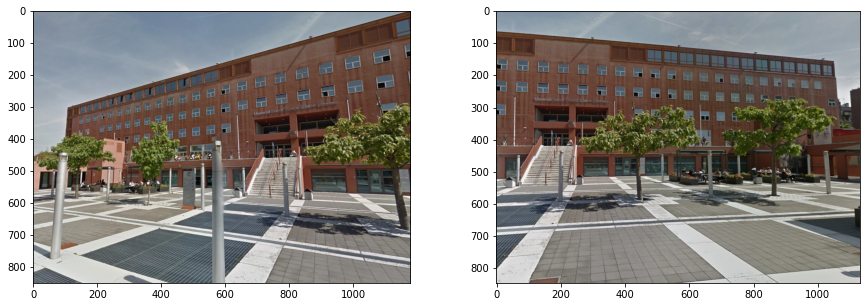

In [226]:
plt.subplot(1,2,1); plt.imshow(cv.cvtColor(im1, cv.COLOR_BGR2RGB));
plt.subplot(1,2,2); plt.imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB));
plt.show()

In [227]:
print('Dimensioni immagine 1: ', im1.shape)
print('Dimensioni immagine 2: ', im2.shape)

Dimensioni immagine 1:  (850, 1179, 3)
Dimensioni immagine 2:  (846, 1131, 3)


Le immagini presentano altezze differenti, viene eseguito quindi un resize per portare l'immagine 2 ad avere la stessa altezza dell'immagine 1 rispettando l'aspect ratio (questo comporta un'inevitabile perdita di dettaglio)

In [228]:
alpha = float(im1.shape[0])/float(im2.shape[0])
dim = (int(im2.shape[1]*alpha), int(im2.shape[0]*alpha))
im2 = cv.resize(im2, dim, interpolation = cv.INTER_AREA)

In [229]:
print('Dimensioni immagine 1 dopo resize: ', im1.shape)
print('Dimensioni immagine 2 dopo resize: ', im2.shape)

Dimensioni immagine 1 dopo resize:  (850, 1179, 3)
Dimensioni immagine 2 dopo resize:  (850, 1136, 3)


Trasformazione dell'immagine in scala di grigi per il calcolo dei keypoints e dell'omografia. Questo permette di semplificare i calcoli senza inficiare sulle prestazioni.

In [230]:
im1_gray = cv.cvtColor(im1, cv.COLOR_BGR2GRAY)
im2_gray = cv.cvtColor(im2, cv.COLOR_BGR2GRAY)

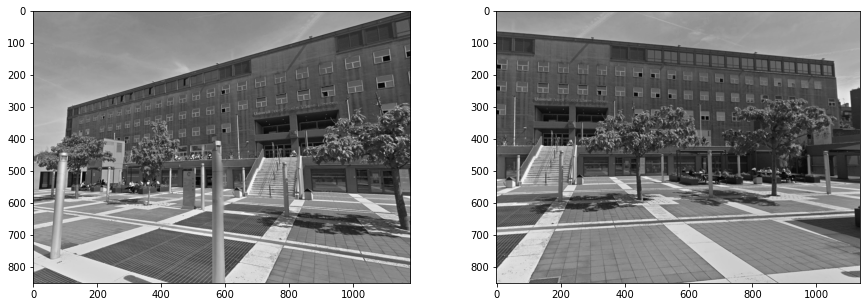

In [231]:
plt.subplot(1,2,1); plt.imshow(im1_gray, cmap='gray');
plt.subplot(1,2,2); plt.imshow(im2_gray, cmap='gray');
plt.show()

Le due immagini si sovrappongono parzialmente nella zona della scalinata, viene quindi applicato l'algoritmo SIFT per individuare i keypoint comuni tra le due immagini.

In [232]:
# Keypoints extraction
sift = cv.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1_gray, None)
(kps2, features2) = sift.detectAndCompute(im2_gray, None)
# Features matching
bf = cv.BFMatcher.create(crossCheck=True)
matches = bf.match(features1, features2)

In [233]:
print('Features immagine 1: ', features1.shape)
print('Features immagine 2: ', features2.shape)
print('Numero keypoints matchati:', len(matches))

Features immagine 1:  (6315, 128)
Features immagine 2:  (5771, 128)
Numero keypoints matchati: 2114


L'algoritmo ha rilevato 6315 keypoints nell'immagine di sinistra e 5771 keypoints nell'immagine di destra descritti da 128 features. L'algoritmo ha identificato 2114 match tra questi. Ovviamente non tutti i match si riferiscono a corrispondenze esatte, per questo motivo di seguito vengono selezionati solo il 10% dei match (~200) che presentano una distanza minore nello spazio delle features. Questo migliora le performance e riduce il costo computazionale.

In [234]:
matches = sorted(matches, key = lambda x: x.distance)[:len(matches)//10]

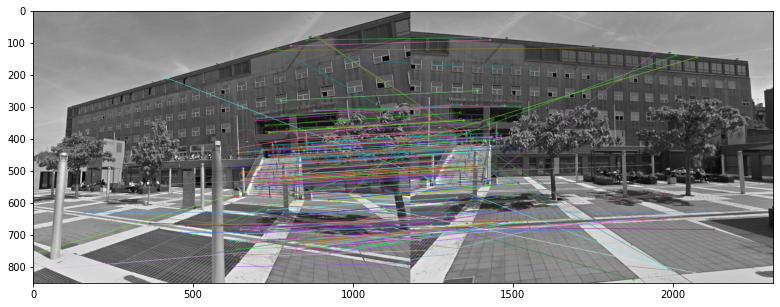

In [235]:
img_match = cv.drawMatches(im1_gray, kps1, im2_gray, kps2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_match);

### 1. Find the homography which describes the transformation from the <u>second</u> set of points to the <u>first</u> one

Di seguito viene definita la funzione che permette di identificare l'omografia corretta per allineare le due immagini. Per farlo viene utilizzata la funzione `findHomography` di `OpenCV` alla quale vengono fornite le coordinate corrispondenti ai match tra le due immagini

Nonostante il trim dei match, come si puó vedere dall'immagine precedente, alcuni dei match considerati non sono corretti. Per questo motivo alla funzione findHomography viene specificato di utilizzare il metodo RANSAC; questo permette di identificare i match corretti valutando la trasformazione che risulta in accordo con la maggior parte dei match.

In [236]:
def myHomography(kps1, kps2, matches):
    train = []
    query = []
    for match in matches:
      train.append(kps1[match.queryIdx].pt)
      query.append(kps2[match.trainIdx].pt)
    
    H = cv.findHomography(np.array(query), np.array(train), cv.RANSAC)[0]
    return H

In [237]:
H = myHomography(kps1, kps2, matches)

In [238]:
print(H)

[[ 2.44479233e-01 -1.53467898e-02  5.79903002e+02]
 [-3.95782239e-01  7.85749190e-01  1.13852485e+02]
 [-7.92679472e-04 -9.88744513e-05  1.00000000e+00]]


Questa é la matrice 3x3 associata alla trasformazione che permette di far combaciare i keypoints dell'immagine 2 a quelli dell'immagine 1.

### 2. Apply the homography to the second image

Per applicare la trasformazione H all'immagine 2 viene utilizzata la funzione `warpPerspective` di `OpenCV`.

A questa, oltre all'immagine da trasformare e alla trasformazione da eseguire, va specificata la dimensione finale dell'immagine 2 trasformata, che corrisponde a quanto si vuole estendere l'immagine 1. Questo valore va scelto in base al caso specifico (posizione relativa tra le immagini) e al risultato desiderato: con pochi bordi neri o con la maggior quantitá di informazioni.
In queso caso é stata scelta come altezza quella dell'immagine iniziale e come larghezza il doppio della larghezza dell'immagine 2.

NB. Dato che la trasformazione é stata individuata é possibile ora tornare a considerare le immagini originali a colori per i prossimi passaggi.

In [239]:
def myWarp(im, H):
    warped_image = cv.warpPerspective(im, H, (im.shape[1]*2, im.shape[0]))
    return warped_image

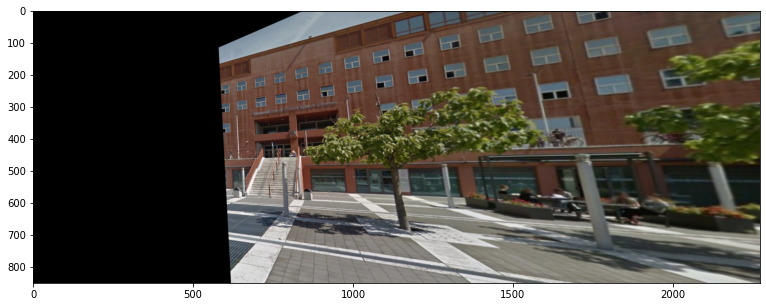

In [240]:
# Apply a perspective warp to stitch the images together
im2_warp = myWarp(im2, H)
plt.imshow(cv.cvtColor(im2_warp, cv.COLOR_BGR2RGB));

Si nota una degradazione nella qualitá dell'immagine che cresce all'aumentare della deformazione

### 3. Integrate the first image

Per ottenere l'immagine finale composta dalle due immagini unite basta sovrapporre  l'immagine 1 all'immagine 2 trasformata.

In [241]:
def myCollage(im_base, im_new):
    collaged_image = im_new.copy()
    collaged_image[0:im_base.shape[0], 0:im_base.shape[1]] = im_base
    return collaged_image

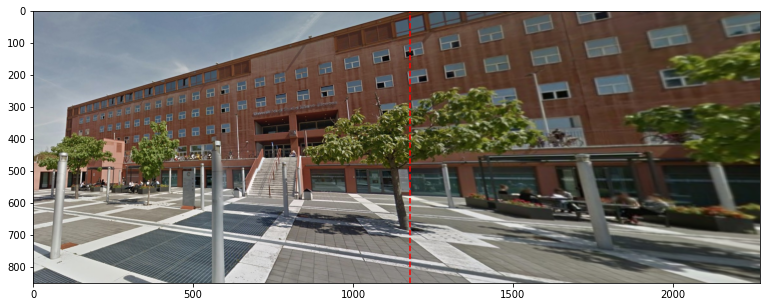

In [242]:
result = myCollage(im1, im2_warp)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB));
plt.axvline(x=im1.shape[1], color='red', ls='--');

La linea rossa rappresenta la zona di giunzione tra le due immagini. Il risultato dell'integrazione é un'immagine correttamente trasformata e ben allineata. Il match é ben riuscito anche dal punto di vista dei colori perché le immagini sono stata scattate nella stesso momento con la stessa fotocamera.

La degradazione della porzione destra é abbastanza visibile. Di seguito viene indagato il motivo analizzando la porzione di immagine 2 che é stata deformata e utilizzata nel collage. Per farlo sono stati:
- individuati i vertici dell'immagine 2 trasformata
- applicata la trasformazione inversa ai vertici
- rappresentati i segmenti tra i punti trasformati sull'immagine 2 originale

In [243]:
cor = np.array([[[im1.shape[1], 0], [result.shape[1], 0], [result.shape[1], im1.shape[0]], [im1.shape[1], im1.shape[0]]]], dtype=np.float32)

H_inv = np.linalg.inv(H)
cor_t = cv.perspectiveTransform(cor, H_inv)[0]

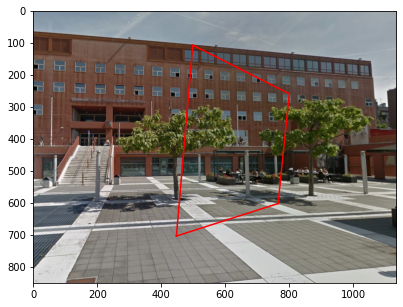

In [244]:
x1, y1 = [cor_t[0][0], cor_t[1][0]], [cor_t[0][1], cor_t[1][1]]
x2, y2 = [cor_t[1][0], cor_t[2][0]], [cor_t[1][1], cor_t[2][1]]
x3, y3 = [cor_t[2][0], cor_t[3][0]], [cor_t[2][1], cor_t[3][1]]
x4, y4 = [cor_t[3][0], cor_t[0][0]], [cor_t[3][1], cor_t[0][1]]

plt.imshow(cv.cvtColor(im2, cv.COLOR_BGR2RGB));

plt.plot(x1, y1, color='r')
plt.plot(x2, y2, color='r')
plt.plot(x3, y3, color='r')
plt.plot(x4, y4, color='r')

plt.show()

É evidente che la porzione utilizzata é molto piccola ed é stata deformata di molto, la perdita di dettaglio é dunque inevitabile.